In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy
from scipy.interpolate import interp1d

from numpy.fft import fftshift, fft2, ifft2, fft, ifft
from numpy import real
from numpy import conj

import tiff_file

%matplotlib notebook


tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


Set the directory for where the data is below.

In [2]:
data_dir = ".\\ExampleData\\"
data_file = "23_osc_100gel_cooling_rollingbgsubtract-200_Bin2x2x2.tif"

#The pixel size for the shearing stage is 0.497 microns. 
#Below, we multiply by 2 because we have binned the data 2x2
pixel_size = 0.497 * 2

In [3]:
images = tiff_file.imread(data_dir + data_file)
print "Number of frames in %s: %s" % (data_file, images.shape[0])

Number of frames in 23_osc_100gel_cooling_rollingbgsubtract-200_Bin2x2x2.tif: 288


## Read the following carefully

Note that the sample data we are using is not the raw images. We have taken the images and, in ImageJ, gone to Process -> Subtract Background. The following window appears and we selected 200 for the "Rolling ball radius" (units of pixels). This will subtract from each pixel in the image the average of all the pixels within a 200 pixel radius. It is a way of removing slowly spatially varying background.

![Window that appears when Subtract Background... is run](.\ExampleData\Capture_BackgroundSubtract.png "Subtract Background Tool in ImageJ")

If there is not a slowly varying background, then this step is probably not needed. 

Another possible step to clean up the data is to use a bandpass filter. To do so, run Process -> FFT -> Bandpass Filter. The following window will come up. Enter the upper size limit of large structures to filter out and the lower size limit for small structures to filter out. Here, I have entered 30 and 4. If you think droplets in the image are larger than 30 pixels, then don't use 30. Use a larger number. You don't want to filter away the droplets. You can select "Autoscale after filtering" and "Process entire stack." 

![Window that appears when FFT Bandpass Filter is run](.\ExampleData\Capture_FFTBandpass.png "Bandpass Filter Tool in ImageJ")

Here is an example showing an image before and after the bandpass filter. You see that the contrast is enhanced and that the large scale structure that seemed to be in the background (probably dirt on one of the glass surfaces) that appeared in the pre-processed data is gone in the bandpassed data. On the left is the pre-processed raw data. On the right is the result after performing the bandpass filter.

![Example of bandpass filtering](.\ExampleData\Capture_BandpassAndNot.png "Images before and after bandpass filter")

For both kinds of image processing, make sure to save the processed image stack as a new tiff file. **Don't overwrite the original data.**

Below we define the function for 2D image autocorrelation

In [4]:
def autocorrelation_2D(image):
    data = image-image.mean() 
    data = data / data.std()
    
    temp = real(fftshift(ifft2(fft2(data)*conj(fft2(data)))))
    temp = temp / (data.shape[0]*data.shape[1])
    
    return temp

In [5]:
def autocorrelation_1D(image, ax):
    # This function computes a 1D correlation
    # of a 2D image. 
    # Input parameters:
    #    image -- a 2D numpy array
    #    ax -- the axis to perform the autocorrelation
    #
    # Note about which axes to use:
    #   for ax = 0: this will correlate things along the vertical direction when displayed using matshow
    #   for ax = 1: this will correlate along the horizontal direction when displayed using matshow
    
    means = image.mean(axis=ax)
    temp = np.tile(means, (image.shape[ax], 1))
    if ax==0:
        data = image - temp
    elif ax==1:
        data = image - temp.transpose()
    else:
        print "ax must be 0 or 1"
        return 0
    
    std_devs = data.std(axis=ax)
    #print "shape of std_devs: ", std_devs.shape #for debugging purposes
    temp = np.tile(std_devs, (image.shape[ax],1))
    if ax==0:
        data = data / temp
    elif ax==1:
        data = data / temp.transpose()
        
    temp = fftshift(ifft(fft(data,axis=ax)*conj(fft(data,axis=ax)),axis=ax),axes=ax)
    temp = real(temp) / data.shape[ax]
       
    if ax==0:
        corr = temp.sum(axis=1)/temp.shape[1]
        return corr[temp.shape[0]/2:]
    elif ax==1:
        corr = temp.sum(axis=0)/temp.shape[0]
        return corr[temp.shape[1]/2:]

In [23]:
def find_where_corr_at_half(corr, val=0.5):
    # This function will actually only find where the correlation function goes to 0.5
    # (which, if properly normalized, means that it dropped 50%) if the "val" is set
    # to 0.5 which is the default. However, you can change that to another value like
    # 0.2 or 1/e or something else. 
    f = interp1d(np.arange(0,len(corr)), corr, kind='linear', fill_value="extrapolate") #create interpolation function
    new_x = np.linspace(0, len(corr), 10*len(corr))  #new x-axis that is 10 times more sampled
    eval_at_new_x = f(new_x) #evaluate the interpolated function over the new range of x-values
    min_index = np.argmin(abs(eval_at_new_x-val)) #find where that is closest to "val" 
    return new_x[min_index]

Where the correlation goes to 50% for axis 0:  6.503251625812906
Where the correlation goes to 50% for axis 1:  4.402201100550275


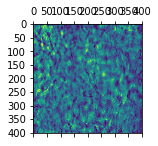

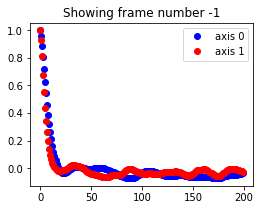

In [24]:
frame_to_show = -1
im = images[frame_to_show]
plt.figure(figsize=(2,2))
plt.matshow(im, fignum=0)
corr2d = autocorrelation_2D(im)
plt.figure(figsize=(4,3))
acorr_0 = autocorrelation_1D(im,0)
acorr_1 = autocorrelation_1D(im,1)
plt.plot(acorr_0,'bo',label='axis 0')
plt.plot(acorr_1,'ro',label='axis 1')
#plt.plot(corr2d[im.shape[0]/2,im.shape[1]/2:], 'go')
#plt.plot(corr2d[im.shape[0]/2:,im.shape[1]/2], 'mo')
print "Where the correlation goes to 50% for axis 0: ", find_where_corr_at_half(acorr_0)
print "Where the correlation goes to 50% for axis 1: ", find_where_corr_at_half(acorr_1)
plt.title("Showing frame number %i" % frame_to_show)
plt.legend(loc=0)

Below, we will loop over all frames in the movie and find where the autocorrelation along x and along y reaches 0.5 (50% of the maximum).

In [25]:
xCorr50 = np.zeros(images.shape[0])
yCorr50 = np.zeros_like(xCorr50)
allXc = np.zeros((images.shape[0], images.shape[1]/2))
allYc = np.zeros((images.shape[0], images.shape[2]/2))
for i in range(images.shape[0]):
    xc = autocorrelation_1D(images[i], 0)
    yc = autocorrelation_1D(images[i], 1)
    xCorr50[i] = find_where_corr_at_half(xc)
    yCorr50[i] = find_where_corr_at_half(yc)
    allXc[i] = xc
    allYc[i] = yc


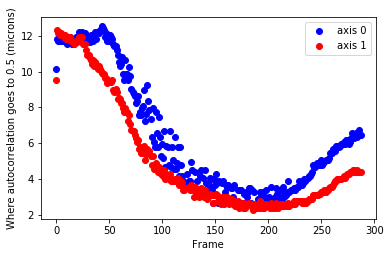

In [26]:
fig = plt.figure(figsize=(6,6/1.618))
plt.plot(xCorr50 * pixel_size, 'bo', label="axis 0")
plt.plot(yCorr50 * pixel_size, 'ro', label="axis 1")
plt.xlabel("Frame")
plt.ylabel("Where autocorrelation goes to 0.5 (microns)")
plt.legend(loc=0)

Text(0,0.5,'Time (frames)')

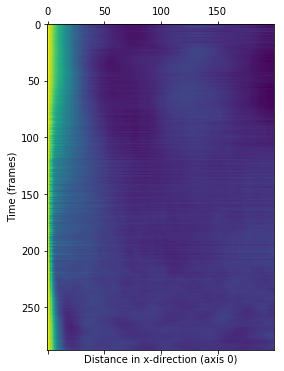

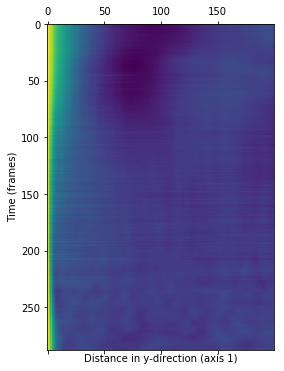

In [27]:
fig = plt.figure(figsize=(6,6))
plt.matshow(allXc[:,:],fignum=0)
plt.xlabel("Distance in x-direction (axis 0)")
plt.ylabel("Time (frames)")

fig = plt.figure(figsize=(6,6))
plt.matshow(allYc[:,:],fignum=0)
plt.xlabel("Distance in y-direction (axis 1)")
plt.ylabel("Time (frames)")

You may want to save the results of this analysis. Perhaps you will want to plot the size of the domains as a function of time for many different trials on top of each other. The best way to do that would be to run through the steps described here for each movie, save the results from each, and then write a new script or notebook that loads in all of that data. 

We will use the pickle format to save the data.

In [28]:
data_results = {} #Initializes a new dictionary
data_results['xCorr_50'] = xCorr50 * pixel_size
data_results['yCorr_50'] = yCorr50 * pixel_size
data_results['data_location'] = data_dir
data_results['data_file'] = data_file
data_results['xcorrelations_alltimes'] = allXc
data_results['ycorrelations_alltimes'] = allYc
data_results['threshold_value'] = 0.5 # <--- change this if you don't use the default for val in 'find_where_corr_at_half'

#Below, we save the data to file
pickle.dump(data_results, open(".\\ExampleData\\" + data_file[:-4] + "_correlationResults.p", 'wb'))

If we want to read the data back in, we would use:
`data = pickle.load("location_of_the_saved_pickle_file\\the_pickle_file.p", 'rb')`